In [2]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

Загружаем картинку

Text(0.5, 1.0, 'Исходное изображение')

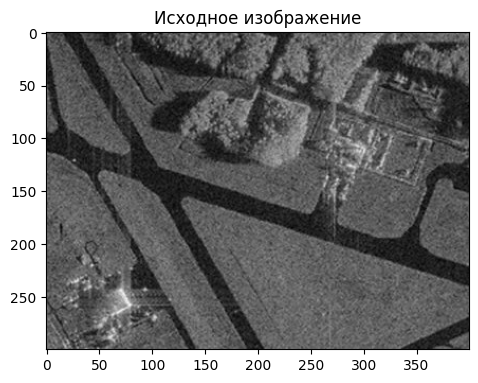

In [3]:
image = cv2.imread('assets/laba4.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap="gray")
plt.title('Исходное изображение')

1. Выделим участок газона

70
224
369
485
632
788
864
1009
1082
996
941
902
871
836
748
729
679
616
560
899
502
449
407
388
307
280
278
241
169
28
7
0


(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

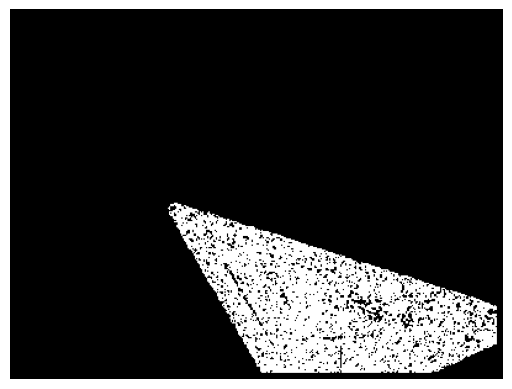

In [4]:
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False


def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask

    return mask*255

seed_point = (250, 250)
mask = region_growing(image_gray, seed_point, homo_average, 5, 12)

plt.imshow(mask, cmap="gray")
plt.axis('off')

2. Реализуем вычисление критерия однородности.

Добавлено пикселей: 77
Добавлено пикселей: 222
Добавлено пикселей: 378
Добавлено пикселей: 515
Добавлено пикселей: 651
Добавлено пикселей: 798
Добавлено пикселей: 900
Добавлено пикселей: 1051
Добавлено пикселей: 1243
Добавлено пикселей: 899
Добавлено пикселей: 970
Добавлено пикселей: 945
Добавлено пикселей: 905
Добавлено пикселей: 862
Добавлено пикселей: 773
Добавлено пикселей: 953
Добавлено пикселей: 722
Добавлено пикселей: 655
Добавлено пикселей: 590
Добавлено пикселей: 560
Добавлено пикселей: 512
Добавлено пикселей: 474
Добавлено пикселей: 430
Добавлено пикселей: 402
Добавлено пикселей: 321
Добавлено пикселей: 297
Добавлено пикселей: 291
Добавлено пикселей: 249
Добавлено пикселей: 176
Добавлено пикселей: 29
Добавлено пикселей: 9
Добавлено пикселей: 0
Добавлено пикселей: 99
Добавлено пикселей: 261
Добавлено пикселей: 0
Добавлено пикселей: 77
Добавлено пикселей: 229
Добавлено пикселей: 393
Добавлено пикселей: 508
Добавлено пикселей: 666
Добавлено пикселей: 814
Добавлено пикселей: 920


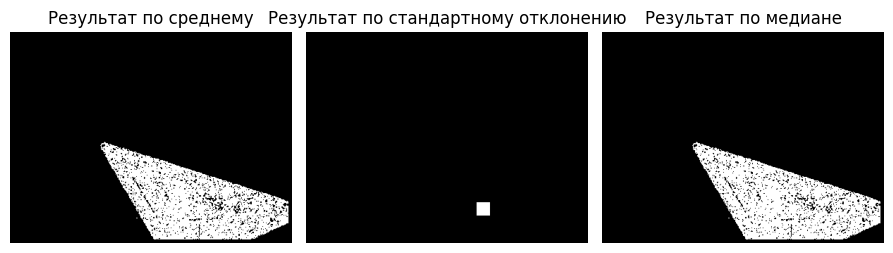

In [5]:
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(mask)
    return abs(av_val - img[point]) <= T

def homo_std_dev(img, mask, point, T):
    region_pixels = img[mask > 0]
    if region_pixels.size == 0:
        return False
    std_dev = np.std(region_pixels)
    return std_dev <= T

def homo_median(img, mask, point, T):
    region_pixels = img[mask > 0]
    if region_pixels.size == 0:
        return False
    median_val = np.median(region_pixels)
    return abs(median_val - img[point]) <= T

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        print(f"Добавлено пикселей: {count}")
        mask += local_mask

    return mask * 255

seed_point = (250, 250)

mask_average = region_growing(image_gray, seed_point, homo_average, 5, 13)


mask_std_dev = region_growing(image_gray, seed_point, homo_std_dev, 5, 8)


mask_median = region_growing(image_gray, seed_point, homo_median, 5, 13)

plt.figure(figsize=(12, 8))

plt.subplot(1, 4, 2)
plt.imshow(mask_average, cmap="gray")
plt.title("Результат по среднему")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_std_dev, cmap="gray")
plt.title("Результат по стандартному отклонению")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(mask_median, cmap="gray")
plt.title("Результат по медиане")
plt.axis('off')

plt.tight_layout()

plt.show()

3. Применим алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

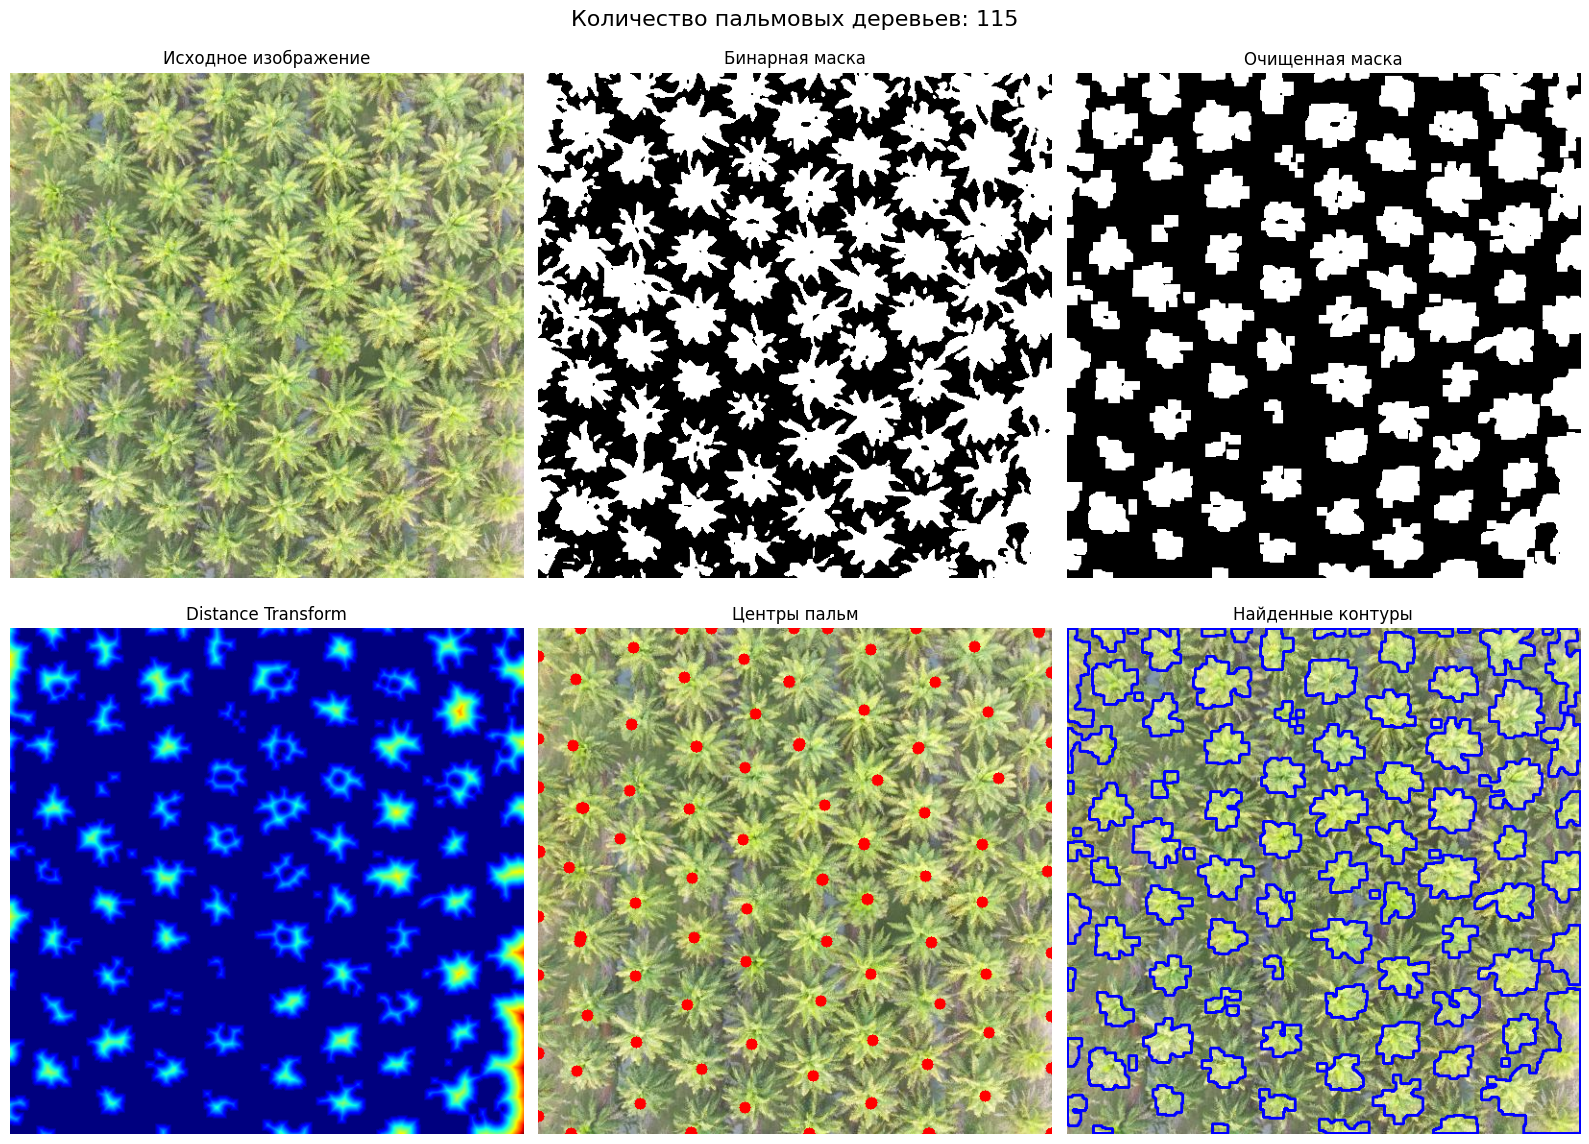

Найдено пальм: 115


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

image = cv2.imread('assets/palm_1.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
smoothed = cv2.GaussianBlur(gray, (9, 9), 0)

_, thresh = cv2.threshold(smoothed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

dist = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

neighborhood_size = 51
local_max = ndimage.maximum_filter(dist, size=neighborhood_size) == dist
local_max[dist < 0.2 * dist.max()] = False

centers = np.column_stack(np.where(local_max))

image_centers = image.copy()
for (y, x) in centers:
    cv2.circle(image_centers, (x, y), 6, (255, 0, 0), -1)

image_contours = image.copy()
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image_contours, contours, -1, (0, 0, 255), 2)

palm_count = len(centers)

plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(thresh, cmap="gray")
plt.title("Бинарная маска")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cleaned, cmap="gray")
plt.title("Очищенная маска")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(dist_norm, cmap="jet")
plt.title("Distance Transform")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image_centers)
plt.title("Центры пальм")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image_contours)
plt.title("Найденные контуры")
plt.axis('off')

plt.suptitle(f"Количество пальмовых деревьев: {palm_count}", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Найдено пальм: {palm_count}")